In [1]:
#importing necessary libraries
from api.mapbox_api_driving import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod
from collections import defaultdict
from shapely.ops import unary_union

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
censusTracts.shape

(869, 63)

In [ ]:
branchInfo.loc[branchInfo['BRANCH'] == 'Roosevelt']

In [ ]:
branchInfo = branchInfo.drop([60,60])
branchInfo = branchInfo.set_index('BRANCH')
branchInfo = branchInfo.reset_index()
branchInfo

In [4]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [5]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [6]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [7]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary, key, iso_dict):
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            iso_dict[df.loc[i, key]] = overlapPolygon
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            dictionary[df.loc[i, key]] = propOverlap
            
            
            if len(df.loc[i, 'to merge list']) > 0:
                hold = (df.loc[i, 'to merge list'][0]).copy()
                c = len(hold.items())
                hold[c] = overlapPolygon
                df.loc[i, 'to merge list']= [hold]
 
            else:
                first = {0:overlapPolygon}
                df.loc[i, 'to merge list'] = [first]
            
    return dictionary


In [8]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [31]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf, idf, scoreString, dictString, cgs, igs, lat, lon, key, travelTime):
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    cdf['to merge list'] = np.empty((len(cdf), 0)).tolist()
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas

    
   
    for i in range(len(idf)):
        # Create a new dictionary for tracking isochrones
        iso_dict = defaultdict(list)
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs], cdf, cgs, dictionary, key, iso_dict)
        idf.loc[i,dictString] = [dictionary]
        idf.loc[i,'iso geometries'] = [iso_dict]
        
        for j in range(len(cdf)):
           
            if dictionary.get(cdf.loc[j, key]) != None:
                score = cdf.loc[j, scoreString]
                cdf.loc[j, scoreString] = score + dictionary.get(cdf.loc[j, key])
            
    for i in range(len(cdf)):
        if len(cdf.loc[i, 'to merge list']) > 0:
            toMerge = (cdf.loc[i, 'to merge list'][0]).copy()
            for tract_key, polygons in toMerge.items():
                merged_geom = unary_union(polygons)
                merged_area, _ = geod.geometry_area_perimeter(merged_geom)
                merged_area *= -1
                area_val = merged_area / cdf.loc[i,'Area']
                cdf.loc[i, 'percent covered by at least one library'] = area_val
            
                
 

    
              
            
        
        print(merged_geom)
           # 
            #
            #area_val = cdf.loc[cdf[key] == tract_key, 'Area'].values
            #merged_geom_dict[tract_key] = merged_area / area_val[0] if len(area_val) > 0 else 0
   
           
    

In [32]:
appendADS(censusTracts,branchInfo, 'score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid', 5)

In [33]:
branchInfo

,BRANCH,LOCATION,geometry,LATITUDE,LONGITUDE,list of dict,iso geometries
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71361 41.99322, -87.71461 41.992...",41.975579,-87.713613,"[{17031140800: 0.10910496440467443, 1703116050...","[{17031140800: POLYGON ((-87.704613 41.967282,..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59684 41.69523, -87.59691 41.693...",41.657198,-87.598838,"[{17031825801: 0.1615035489776389, 17031826401...",[{17031825801: POLYGON ((-87.57759794954075 41...
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72348 41.81848, -87.72559 41.816...",41.801108,-87.726484,"[{17031650200: 0.0254912176417698, 17031650100...","[{17031650200: POLYGON ((-87.727484 41.784578,..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76482 41.90631, -87.76582 41.906...",41.889173,-87.765820,"[{17031252101: 0.39452842303857544, 1703181300...","[{17031252101: POLYGON ((-87.76482 41.872638, ..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.78829 41.96818, -87.78832 41.962...",41.953123,-87.779285,"[{17031190402: 0.022557937206714188, 170311904...","[{17031190402: POLYGON ((-87.774137 41.938123,..."
...,...,...,...,...,...,...,...
77,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.64217 41.70308, -87.64351 41.701...",41.677906,-87.643168,"[{17031821402: 0.990325261989984, 17031821200:...",[{17031821402: MULTIPOLYGON (((-87.65133916424...
78,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66729 41.91073, -87.66881 41.909...",41.895947,-87.668293,"[{17031280100: 0.001197490335336308, 170318381...","[{17031280100: POLYGON ((-87.647293 41.887913,..."
79,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.63095 41.78607, -87.63108 41.779...",41.751018,-87.614951,"[{17031490200: 0.006124736067597431, 170314409...","[{17031490200: POLYGON ((-87.613951 41.726017,..."
80,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.74373, -87.64405 41.744...",41.720695,-87.643048,"[{17031750500: 0.002029252118561393, 170317506...","[{17031750500: POLYGON ((-87.662048 41.685918,..."


In [34]:
censusTracts

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",1.000000,"[{0: POLYGON ((-87.720304 41.683963, -87.72006...",1.081697e+00,1.000000
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",1.970204,[{0: MULTIPOLYGON (((-87.72006475363558 41.683...,3.526503e+05,0.970204
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.69127, -87.71937 41.691...",0.627963,"[{0: POLYGON ((-87.721459 41.68445, -87.720862...",2.782659e+06,0.042506
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.72043 41.69857, -87.72007 41.698...",1.065450,"[{0: POLYGON ((-87.720066 41.698576, -87.71980...",1.319688e+06,0.065450
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.72075 41.70204, -87.72075 ...",1.000000,[{0: MULTIPOLYGON (((-87.72074518791808 41.701...,1.577396e+01,1.000000
...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.62764 41.88206, -87.62759 41.882...",0.979310,"[{0: POLYGON ((-87.617221 41.876863, -87.61661...",8.033379e+05,0.016882
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.62086 41.88188, -87.62082 41.882...",0.432512,[{0: POLYGON ((-87.6164463961894 41.8809129439...,4.902799e+05,0.318494
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.62431 41.88911, -87.62431 ...",0.455434,"[{0: MULTIPOLYGON (((-87.62081 41.889051, -87....",5.956278e+05,0.455434
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.61754 41.89345, -87.61716 41.893...",0.237180,"[{0: POLYGON ((-87.615052 41.89081, -87.616801...",5.776787e+05,0.237180


In [13]:
len(censusTracts.loc[0,'to merge list'][0])

1

In [35]:
censusTracts.sort_values(by = 'score', ascending = False)

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library
322,17031340600,"Census Tract 3406, Cook County, Illinois","POLYGON ((-87.63625 41.83088, -87.63623 41.830...",3.656036,"[{0: POLYGON ((-87.633568 41.827499, -87.63314...",4.965761e+05,0.528151
323,17031351500,"Census Tract 3515, Cook County, Illinois","POLYGON ((-87.62907 41.82742, -87.62904 41.827...",3.561942,"[{0: POLYGON ((-87.626987 41.829344, -87.62709...",1.662212e+05,1.000000
320,17031380600,"Census Tract 3806, Cook County, Illinois","POLYGON ((-87.62931 41.82368, -87.62928 41.823...",3.425128,"[{0: POLYGON ((-87.624295 41.823344, -87.62371...",8.388936e+05,0.824290
377,17031832900,"Census Tract 8329, Cook County, Illinois","POLYGON ((-87.66666 41.87635, -87.66657 41.876...",3.157499,"[{0: POLYGON ((-87.664287 41.876372, -87.66279...",4.045824e+05,0.403668
348,17031340500,"Census Tract 3405, Cook County, Illinois","POLYGON ((-87.63637 41.83453, -87.63634 41.834...",3.147072,"[{0: POLYGON ((-87.631368 41.831344, -87.63088...",4.354491e+05,0.356593
...,...,...,...,...,...,...,...
816,17031980000,"Census Tract 9800, Cook County, Illinois","MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...",0.000000,[],1.902470e+07,NaN
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",0.000000,[],1.799139e+05,NaN
818,17031770602,"Census Tract 7706.02, Cook County, Illinois","POLYGON ((-87.90416 42.00363, -87.90424 42.003...",0.000000,[],6.839449e+05,NaN
820,17031807600,"Census Tract 8076, Cook County, Illinois","POLYGON ((-87.70867 42.01896, -87.70867 42.018...",0.000000,[],1.930083e+04,NaN


In [36]:
censusTracts.sort_values(by = 'percent covered by at least one library', ascending = False)

,geoid,qualifying name,geometry,score,to merge list,Area,percent covered by at least one library
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",1.000000,"[{0: POLYGON ((-87.720304 41.683963, -87.72006...",1.081697,1.0
709,17031160800,"Census Tract 1608, Cook County, Illinois","POLYGON ((-87.71757 41.95379, -87.71683 41.953...",1.000000,"[{0: POLYGON ((-87.716833 41.953804, -87.71658...",657627.985181,1.0
302,17031381700,"Census Tract 3817, Cook County, Illinois","POLYGON ((-87.62895 41.80662, -87.62892 41.808...",1.446341,"[{0: POLYGON ((-87.626568 41.808113, -87.62818...",196801.226876,1.0
301,17031381800,"Census Tract 3818, Cook County, Illinois","POLYGON ((-87.62566 41.80563, -87.62497 41.805...",1.000000,"[{0: POLYGON ((-87.624969 41.805616, -87.62468...",319366.364335,1.0
298,17031612100,"Census Tract 6121, Cook County, Illinois","POLYGON ((-87.64972 41.80152, -87.64826 41.801...",1.346931,"[{0: POLYGON ((-87.645568 41.795282, -87.64604...",326355.476404,1.0
...,...,...,...,...,...,...,...
818,17031770602,"Census Tract 7706.02, Cook County, Illinois","POLYGON ((-87.90416 42.00363, -87.90424 42.003...",0.000000,[],683944.873982,NaN
820,17031807600,"Census Tract 8076, Cook County, Illinois","POLYGON ((-87.70867 42.01896, -87.70867 42.018...",0.000000,[],19300.833652,NaN
859,17031010100,"Census Tract 101, Cook County, Illinois","POLYGON ((-87.67628 42.02296, -87.67597 42.022...",0.000000,[],366016.154177,NaN
860,17031810000,"Census Tract 8100, Cook County, Illinois","MULTIPOLYGON (((-87.66153 42.01346, -87.66155 ...",0.000000,[],4555.142781,NaN


In [ ]:
branchCopy[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchCopy['LOCATION']]
branchCopy = branchCopy.drop(columns='LOCATION')
branchCopy = gpd.GeoDataFrame(
     branchCopy, geometry=gpd.points_from_xy(branchCopy.Longitude, branchCopy.Latitude), crs="EPSG:3435")

base = censusTracts.plot(color='white', edgecolor='black')


Text(0.5, 1.0, 'Percent of Coverage')

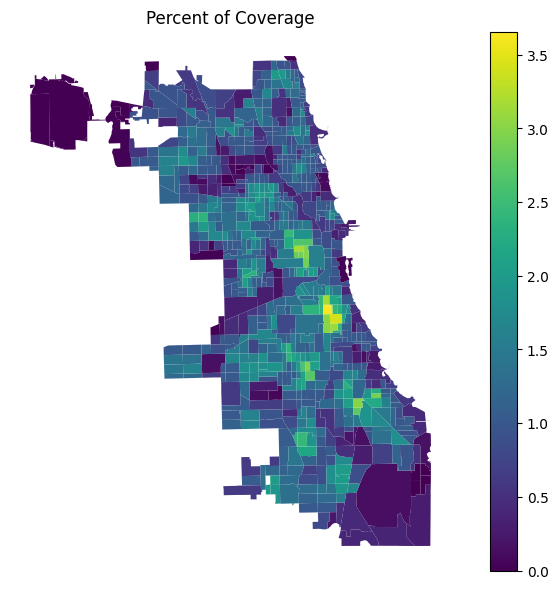

In [39]:
ax = censusTracts.plot(column = 'score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score of overlapping coverage")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


Text(0.5, 1.0, 'Percent of Coverage')

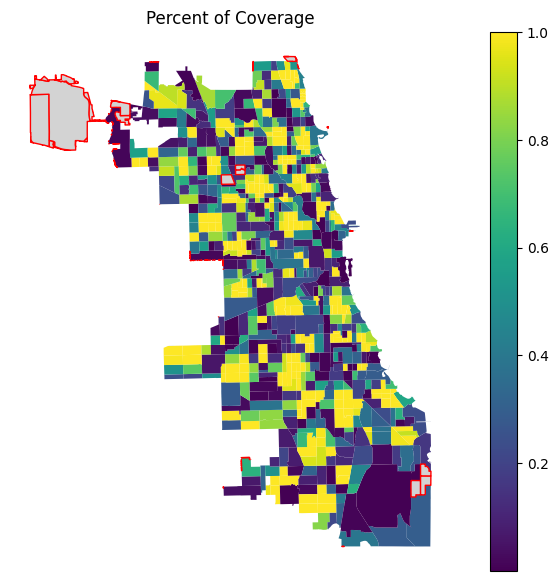

In [38]:
ax = censusTracts.plot(column = 'percent covered by at least one library', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")